In [14]:
import numpy as np
import json
from PIL import Image, ImageDraw
import os
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [15]:
train_image_dir = "../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen"

image_paths_train = []

for i in os.listdir(train_image_dir):
    folder_path = os.path.join(train_image_dir, i)
    if i != '.DS_Store':
        image_paths_train.append(folder_path)

In [16]:
train_label_dir = "../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen"

label_paths_train = []

for i in os.listdir(train_label_dir):
    folder_path = os.path.join(train_label_dir, i)
    if i != '.DS_Store':
        label_paths_train.append(folder_path)

In [17]:
df_image_paths_train = pd.DataFrame({"Index": "", "Image_Path": image_paths_train})
df_label_paths_train = pd.DataFrame({"Index": "", "Target_Path": label_paths_train})

In [18]:
filter_instanceIds = df_label_paths_train[df_label_paths_train['Target_Path'].str.contains('instanceIds')]
filter_color = df_label_paths_train[df_label_paths_train['Target_Path'].str.contains('color')]
filter_labelIds = df_label_paths_train[df_label_paths_train['Target_Path'].str.contains('labelIds')]

df_label_paths_train = df_label_paths_train.drop(filter_instanceIds.index)
df_label_paths_train = df_label_paths_train.drop(filter_color.index)
df_label_paths_train = df_label_paths_train.drop(filter_labelIds.index)

In [19]:
index_tab = []
for el in df_image_paths_train['Image_Path']:
    file_name = os.path.splitext(os.path.basename(el))[0]
    file_name = file_name.replace("_leftImg8bit", "")
    index_tab.append(file_name)
df_image_paths_train['Index'] = index_tab

In [20]:
index_tab = []
for el in df_label_paths_train['Target_Path']:
    file_name = os.path.splitext(os.path.basename(el))[0]
    file_name = file_name.replace("_gtFine_polygons", "")
    index_tab.append(file_name)
df_label_paths_train['Index'] = index_tab

In [21]:
df_train = pd.merge(df_image_paths_train, df_label_paths_train, on='Index', how='left')
df_train

,Index,Image_Path,Target_Path
0,aachen_000079_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000079_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000079_000019_gtFine_polygons.json
1,aachen_000073_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000073_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000073_000019_gtFine_polygons.json
2,aachen_000100_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000100_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000100_000019_gtFine_polygons.json
3,aachen_000006_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000006_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000006_000019_gtFine_polygons.json
4,aachen_000037_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000037_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000037_000019_gtFine_polygons.json
...,...,...,...
169,aachen_000025_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000025_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000025_000019_gtFine_polygons.json
170,aachen_000156_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000156_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000156_000019_gtFine_polygons.json
171,aachen_000091_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000091_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000091_000019_gtFine_polygons.json
172,aachen_000050_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000050_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000050_000019_gtFine_polygons.json


In [22]:
for file_target in df_train['Target_Path']:
    with open(file_target, 'r') as f:
        data = json.load(f)
    
    polygon_tab = []
    for ob in data['objects']:
        if ob['label'] == 'car':
            polygon_tab.append(ob['polygon'])
    
    mask = np.zeros((data['imgHeight'], data['imgWidth'], 2), dtype=np.uint8)
    mask_image = Image.new("L", (data['imgWidth'], data['imgHeight']), 0)

    for masks in polygon_tab:
        mask_tab = []
        for x, y in masks:
            mask_tab.append((x, y))
        ImageDraw.Draw(mask_image).polygon(mask_tab, outline=1, fill=255)

    mask = np.array(mask_image)
    file_npy = os.path.splitext(os.path.basename(file_target))[0]
    file_npy = file_npy.replace("_gtFine_polygons", "")
    np.save(f"./data/{file_npy}.npy", mask)

In [23]:
npy_mask = "./data/"
npy_tab = []

for i in os.listdir(npy_mask):
    npy_file_list = os.path.splitext(os.path.basename(i))[0]
    npy_tab.append({"Index": npy_file_list, "NPY_Path": i})

npy_tab = pd.DataFrame(npy_tab)
df_train = pd.merge(df_train, npy_tab, on='Index', how='left')
df_train

,Index,Image_Path,Target_Path,NPY_Path
0,aachen_000079_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000079_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000079_000019_gtFine_polygons.json,aachen_000079_000019.npy
1,aachen_000073_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000073_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000073_000019_gtFine_polygons.json,aachen_000073_000019.npy
2,aachen_000100_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000100_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000100_000019_gtFine_polygons.json,aachen_000100_000019.npy
3,aachen_000006_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000006_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000006_000019_gtFine_polygons.json,aachen_000006_000019.npy
4,aachen_000037_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000037_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000037_000019_gtFine_polygons.json,aachen_000037_000019.npy
...,...,...,...,...
169,aachen_000025_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000025_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000025_000019_gtFine_polygons.json,aachen_000025_000019.npy
170,aachen_000156_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000156_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000156_000019_gtFine_polygons.json,aachen_000156_000019.npy
171,aachen_000091_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000091_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000091_000019_gtFine_polygons.json,aachen_000091_000019.npy
172,aachen_000050_000019,../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000050_000019_leftImg8bit.png,../Data/files/Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000050_000019_gtFine_polygons.json,aachen_000050_000019.npy


In [24]:
from sklearn.model_selection import train_test_split

X = df_train['Image_Path']
y = df_train['NPY_Path']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [44]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(139,)
(139,)
(35,)
(35,)


In [59]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from tensorflow.keras.layers import Reshape

In [60]:
# Définir une fonction pour prétraiter les images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Charger l'image en taille 224x224 (taille attendue par VGG16)
    img_array = img_to_array(img)  # Convertir l'image en tableau numpy
    return img_array

# Prétraiter les images d'entraînement
X_train_processed = np.array([preprocess_image(img_path) for img_path in X_train])

# Prétraiter les images de test
X_test_processed = np.array([preprocess_image(img_path) for img_path in X_test])

In [61]:
# Charger les masques binaires d'entraînement et de test
y_train_processed = np.array([np.load('./data/' + mask_path) for mask_path in y_train])
y_test_processed = np.array([np.load('./data/' + mask_path) for mask_path in y_test])

In [62]:
# Fonction pour redimensionner les masques binaires
def resize_masks(masks, target_size):
    resized_masks = []
    for mask in masks:
        resized_mask = resize(mask, target_size, mode='constant', preserve_range=True)
        resized_masks.append(resized_mask)
    return np.array(resized_masks)

# Redimensionner les masques binaires d'entraînement et de test
target_size = (224, 224)
y_train_resized = resize_masks(y_train_processed, target_size)
y_test_resized = resize_masks(y_test_processed, target_size)


In [63]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Verrouillez les poids du modèle de base
base_model.trainable = False

In [64]:
# Ajouter une nouvelle couche Dense adaptée à vos besoins
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(224 * 224, activation='sigmoid')(x)
output = Reshape((224, 224))(output)  # Reshape pour obtenir une sortie de la même forme que vos masques binaires

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=output)

In [65]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
model.fit(X_train_processed, y_train_resized, epochs=10, batch_size=32, validation_data=(X_test_processed, y_test_resized))

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.0288 - loss: -63.0848 - val_accuracy: 0.2876 - val_loss: -284.5368
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - accuracy: 0.3103 - loss: -244.0953 - val_accuracy: 0.4189 - val_loss: -285.3389
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - accuracy: 0.4023 - loss: -264.2003 - val_accuracy: 0.5045 - val_loss: -285.3162
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - accuracy: 0.4817 - loss: -248.8954 - val_accuracy: 0.5194 - val_loss: -285.3893
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - accuracy: 0.4980 - loss: -260.9285 - val_accuracy: 0.5453 - val_loss: -285.3743
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.5128 - loss: -259.2994 - val_accuracy: 0.5471 - val_loss: -285.3845
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.5341 - loss: -244.8471 - val_accuracy: 0.5508 - val_loss: -285.3344
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - accuracy: 0.5285 - loss: -257.3145 - val_

In [68]:
import cv2
import matplotlib.pyplot as plt

# Charger l'image de test
test_image_path = "../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/bochum/bochum_000000_000313_leftImg8bit.png"
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)  # Convertir en RVB si nécessaire
test_image_resized = cv2.resize(test_image, (224, 224))  # Redimensionner l'image

In [70]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_image(image):
    # Redimensionner l'image à la taille attendue par VGG16
    resized_image = cv2.resize(image, (224, 224))
    # Prétraiter l'image selon les spécifications de VGG16
    preprocessed_image = preprocess_input(resized_image)
    return preprocessed_image

In [71]:
# Prétraiter l'image de test
preprocessed_test_image = preprocess_image(test_image_resized)


In [72]:
# Appliquer le modèle pour la prédiction
predicted_mask = model.predict(np.expand_dims(preprocessed_test_image, axis=0))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


In [73]:
# Post-traitement du masque binaire (par exemple, seuillage)
threshold = 0.5
binary_mask = (predicted_mask > threshold).astype(np.uint8)

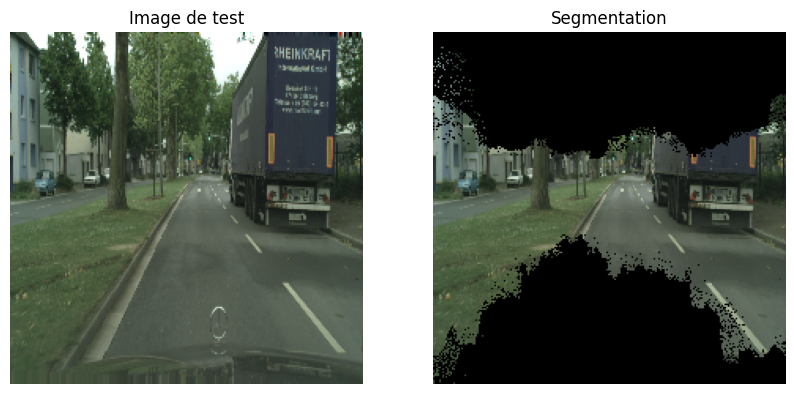

In [74]:
# Superposer le masque binaire sur l'image originale
segmented_image = cv2.bitwise_and(test_image_resized, test_image_resized, mask=binary_mask)

# Afficher l'image de test et la segmentation résultante
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image_resized)
plt.title('Image de test')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title('Segmentation')
plt.axis('off')

plt.show()